<a href="https://colab.research.google.com/github/negarkamali/OOS/blob/main/Intent_classification_conforml_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import requests
import json
import re  # Import the regular expression module
import pandas as pd

url = "https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_oos_plus.json"
response = requests.get(url)

if response.status_code == 200:
    # Save the file content to a file in the current working directory
    with open("data_oos_plus.json", "w") as file:
        file.write(response.text)
    print("File downloaded successfully!")
else:
    print("Failed to download the file. Status code:", response.status_code)




File downloaded successfully!


In [43]:
import json
import re
import requests

url = "https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_oos_plus.json"
response = requests.get(url)

if response.status_code == 200:
    # Convert the file content to JSON
    data = json.loads(response.text)

    # Define a function to clean text
    def clean_text(text):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove non-alphanumeric characters
        tokens = text.split()  # Simple tokenization (splitting by spaces)
        return ' '.join(tokens)

    # Clean the data
    cleaned_data = {}
    for key, value in data.items():
        cleaned_data[key] = [(clean_text(item[0]), item[1]) for item in value]

    # Save the cleaned data to a JSON file
    with open('cleaned_data.json', 'w') as f:
        json.dump(cleaned_data, f, indent=4)

    print("Data cleaned and saved to 'cleaned_data.json'")
else:
    print("Failed to download the file. Status code:", response.status_code)


Data cleaned and saved to 'cleaned_data.json'


In [50]:
import json
import nltk
from nltk.tokenize import word_tokenize

# Ensure that you have the punkt tokenizer models downloaded
nltk.download('punkt')

import json
from nltk.tokenize import word_tokenize

def tokenize_sentence(sentence):
    return word_tokenize(sentence)

def tokenize_data(input_path, output_path=None):
    # Load the data
    with open(input_path, 'r') as f:
        data = json.load(f)

    # Tokenize the data
    tokenized_data = {}
    for key, values in data.items():
        tokenized_data[key] = [[tokenize_sentence(sentence), label] for sentence, label in values]

    # Save the tokenized data (optional)
    if output_path:
        with open(output_path, 'w') as f:
            json.dump(tokenized_data, f, indent=4)

    return tokenized_data

# Input and output file paths
input_path = 'cleaned_data.json'
output_path = 'tokenized_data.json'

# Tokenize and save the data
tokenized_data = tokenize_data(input_path, output_path)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [52]:
import json
import tensorflow_hub as hub
import numpy as np
import os

# Load Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def embed_sentences(sentences):
    return embed(sentences)

def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def preprocess_and_save(data, output_file):
    for key in data:
        sentences = [item[0] for item in data[key]]
        embeddings = embed_sentences(sentences)
        for i, item in enumerate(data[key]):
            item[0] = embeddings[i].numpy().tolist()  # Convert embedding to list
    with open(output_file, 'w') as f:
        json.dump(data, f)

if __name__ == "__main__":
    input_file = 'cleaned_data.json'
    output_file = 'data_oos_plus_embedded.json'
    data = load_data(input_file)
    preprocess_and_save(data, output_file)

In [54]:
import json
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def load_and_preprocess_data():
    # Define file path
    file_path = 'data_oos_plus_embedded.json'

    # Load data from JSON file
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Separate features (X) and labels (y) for in-scope and out-of-scope data
    X_train, y_train = zip(*[(embedding, label) for embedding, label in data["train"]])
    X_val, y_val = zip(*[(embedding, label) for embedding, label in data["val"]])
    X_test, y_test = zip(*[(embedding, label) for embedding, label in data["test"]])

    X_train_oos, y_train_oos = zip(*[(embedding, 'oos') for embedding, label in data["oos_train"]])
    X_val_oos, y_val_oos = zip(*[(embedding, 'oos') for embedding, label in data["oos_val"]])
    X_test_oos, y_test_oos = zip(*[(embedding, 'oos') for embedding, label in data["oos_test"]])

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)

    X_train_oos = np.array(X_train_oos)
    X_val_oos = np.array(X_val_oos)
    X_test_oos = np.array(X_test_oos)

    print("X_train shape:", (X_train).shape)
    print("X_train_oos shape:", (X_train_oos).shape)
    # Combine in-scope and out-of-scope data
    X_train_combined = np.vstack([X_train, X_train_oos])
    X_val_combined = np.vstack([X_val, X_val_oos])
    X_test_combined = np.vstack([X_test, X_test_oos])

    y_train_combined = y_train + y_train_oos
    y_val_combined = y_val + y_val_oos
    y_test_combined = y_test + y_test_oos

    # Convert labels to integers using LabelEncoder, fitting on the combined label set
    label_encoder = LabelEncoder()
    y_train_combined = label_encoder.fit_transform(y_train_combined)
    y_val_combined = label_encoder.transform(y_val_combined)
    y_test_combined = label_encoder.transform(y_test_combined)

    # Convert integer labels to one-hot encoding
    y_train_combined = to_categorical(y_train_combined)
    y_val_combined = to_categorical(y_val_combined)
    y_test_combined = to_categorical(y_test_combined)


    return (X_train_combined, y_train_combined), (X_val_combined, y_val_combined), (X_test_combined, y_test_combined), label_encoder

if __name__ == "__main__":
    (X_train, y_train), (X_val, y_val), (X_test, y_test), label_encoder = load_and_preprocess_data()


X_train shape: (15000, 512)
X_train_oos shape: (250, 512)


In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import recall_score
import numpy as np
import os

In [67]:
from sklearn.model_selection import train_test_split
# Load preprocessed data
(X_train, y_train), (X_val, y_val), (X_test, y_test), label_encoder = load_and_preprocess_data()
# Convert y_test from one-hot encoding to label encoding for stratification
y_test_labels = np.argmax(y_test, axis=1)

# Split test set into calibration and final test set (50-50 split)
X_cal, X_test_final, y_cal, y_test_final = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)


X_train shape: (15000, 512)
X_train_oos shape: (250, 512)


In [59]:
# Define and compile the model
model = Sequential([
    Dense(200, input_shape=(X_train.shape[1],), activation='tanh'),
    Dropout(0.5),
    Dense(200, activation='tanh'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

In [60]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)


Epoch 1/50
954/954 [==============================] - 7s 6ms/step - loss: 2.2724 - accuracy: 0.5370 - val_loss: 0.6421 - val_accuracy: 0.8706
Epoch 2/50
954/954 [==============================] - 4s 4ms/step - loss: 0.6218 - accuracy: 0.8388 - val_loss: 0.3963 - val_accuracy: 0.9071
Epoch 3/50
954/954 [==============================] - 4s 4ms/step - loss: 0.4377 - accuracy: 0.8815 - val_loss: 0.3345 - val_accuracy: 0.9232
Epoch 4/50
954/954 [==============================] - 5s 5ms/step - loss: 0.3583 - accuracy: 0.9018 - val_loss: 0.3160 - val_accuracy: 0.9226
Epoch 5/50
954/954 [==============================] - 4s 4ms/step - loss: 0.3128 - accuracy: 0.9115 - val_loss: 0.3039 - val_accuracy: 0.9245
Epoch 6/50
954/954 [==============================] - 4s 4ms/step - loss: 0.2878 - accuracy: 0.9142 - val_loss: 0.2865 - val_accuracy: 0.9310
Epoch 7/50
954/954 [==============================] - 5s 5ms/step - loss: 0.2676 - accuracy: 0.9223 - val_loss: 0.2867 - val_accuracy: 0.9287
Epoch 

In [68]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_final, y_test_final)
print("Test Accuracy:", accuracy)

86/86 [==============================] - 1s 7ms/step - loss: 0.9753 - accuracy: 0.8535
Test Accuracy: 0.8534545302391052


In [69]:

# Identify the 'oos' class index
oos_class_index = label_encoder.transform(['oos'])[0]

# Predictions for out-of-scope data
oos_predictions = model.predict(X_test_final[y_test_final[:, oos_class_index] == 1])
oos_predictions_labels = np.argmax(oos_predictions, axis=-1)

# True labels for out-of-scope data
y_test_oos_true_labels = np.full(oos_predictions_labels.shape, oos_class_index)

# Calculate recall for out-of-scope data
oos_recall = recall_score(y_test_oos_true_labels, oos_predictions_labels, average='micro')
print("Out-of-scope Recall:", oos_recall)


16/16 [==============================] - 0s 2ms/step
Out-of-scope Recall: 0.478


conformal prediction

In [71]:
 #Convert the target values from one-hot encoding to label encoding

y_train_labels = np.argmax(y_train, axis=1)
y_cal_labels = np.argmax(y_cal, axis=1)

from sklearn.neural_network import MLPClassifier
# Initialize and train the MLP classifier
clf = MLPClassifier(random_state=42, max_iter=500)  # You may need to adjust max_iter
clf.fit(X_train, y_train_labels)

y_pred_proba = clf.predict_proba(X_train)

In [76]:
!pip install mapie

# Initialize MAPIE
from mapie.classification import MapieClassifier
mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="score")
mapie_score.fit(X_cal, y_cal_labels)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 1.5 MB/s eta 0:00:00


MapieClassifier(cv='prefit',
                estimator=MLPClassifier(max_iter=500, random_state=42),
                method='score')

In [77]:
mapie_score.fit(X_cal, y_cal_labels)

alpha = [0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_train, alpha=alpha)

In [81]:

results = pd.DataFrame(list(map(np.ravel, y_ps_score)))
results['prediction'] = y_pred_score

y_train_labels = np.argmax(y_train, axis=1)
results['label'] = y_train_labels

In [90]:
results

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,prediction,label,true_count
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,132,132,1
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,132,132,1
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,132,132,1
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [82]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed
    # display.float_format = lambda x: '{:,.2f}'.format(x)  # set as needed
set_pandas_display_options()

In [97]:
filtered_results = results.loc[results['prediction'] != results['label']]
print("Shape of filtered_results:", filtered_results.shape)

Shape of filtered_results: (1, 154)


In [84]:
y_pred_score_without, y_ps_score_without = mapie_score.predict(X_test, alpha=alpha)
results_without = pd.DataFrame(list(map(np.ravel, y_ps_score_without)))
results_without['prediction'] = y_pred_score_without

In [88]:
y_test_labels = np.argmax(y_test, axis=1)
results_without['label'] = y_test_labels

In [89]:
print(results_without)

          0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24     25     26     27     28     29     30     31     32     33     34     35     36     37     38     39     40     41     42     43     44     45     46     47     48     49     50     51     52     53     54     55     56     57     58     59     60     61     62     63     64     65     66     67     68     69     70     71     72     73     74     75     76     77     78     79     80     81     82     83     84     85     86     87     88     89     90     91     92     93     94     95     96     97     98     99    100    101    102    103    104    105    106    107    108    109    110    111    112    113    114    115    116    117    118    119    120    121    122    123    124    125    126    127    128    129    130    131    132    133    134    135    136    137    138    139    140  \
0    

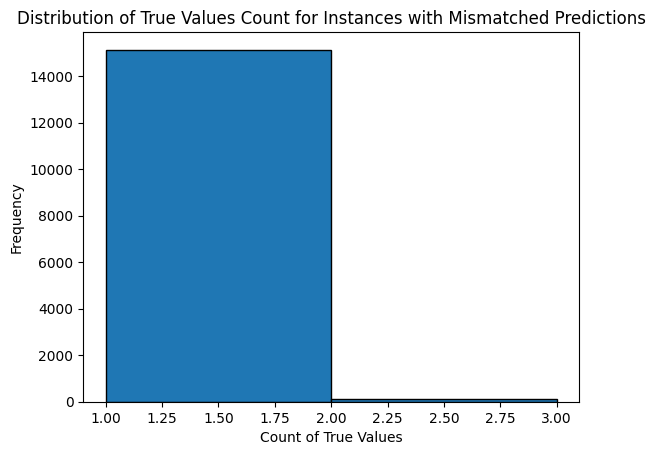

In [86]:
# Plotting the histogram
import matplotlib.pyplot as plt

results['true_count'] = results.iloc[:, :-2].apply(lambda row: sum(row == True), axis=1)
plt.hist(results['true_count'], bins=range(min(results['true_count']), max(results['true_count']) + 1), edgecolor='black')
plt.title('Distribution of True Values Count for Instances with Mismatched Predictions')
plt.xlabel('Count of True Values')
plt.ylabel('Frequency')
plt.show()

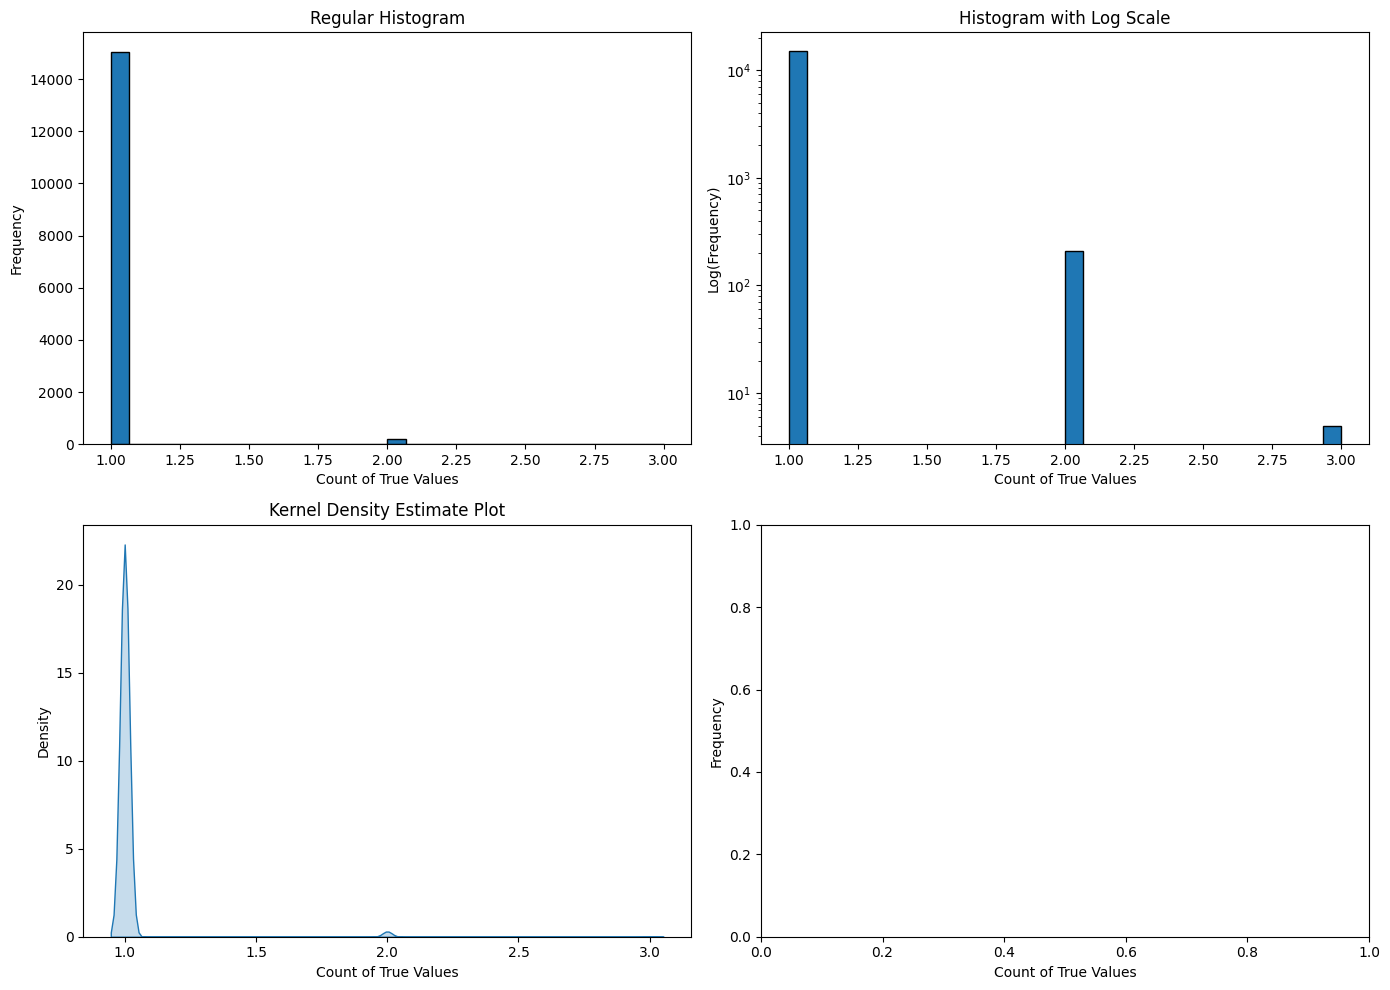

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the true count
results['true_count'] = results.iloc[:, :-2].apply(lambda row: sum(row == True), axis=1)

# Plotting with different strategies
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Regular Histogram
axes[0, 0].hist(results['true_count'], bins=30, edgecolor='black')
axes[0, 0].set_title('Regular Histogram')
axes[0, 0].set_xlabel('Count of True Values')
axes[0, 0].set_ylabel('Frequency')

# Log Scale
axes[0, 1].hist(results['true_count'], bins=30, edgecolor='black', log=True)
axes[0, 1].set_title('Histogram with Log Scale')
axes[0, 1].set_xlabel('Count of True Values')
axes[0, 1].set_ylabel('Log(Frequency)')

# KDE Plot
sns.kdeplot(results['true_count'], ax=axes[1, 0], fill=True)
axes[1, 0].set_title('Kernel Density Estimate Plot')
axes[1, 0].set_xlabel('Count of True Values')
axes[1, 0].set_ylabel('Density')



axes[1, 1].set_xlabel('Count of True Values')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
